<a href="https://colab.research.google.com/github/zhexuandliu/Biological-LM/blob/main/Protein_Language_Model_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Protein Language Model Demo

This notebook accompanies the paper "Primer on Language Models for Biological Research". Here, we demonstrate three approaches for applying a pre-trained protein language model to downstream applications:

1. Direct Prediction

2. Embedding Analysis

3. Transfer Learning

This illustrates these methods in the context of a protein language model (ESM2), but the general methodologies apply across any natural language or biological language model.

The code below was adapted from the HuggingFace tutorial for ESM. See the [original notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling.ipynb) for more examples using this model.

# Setup

We start with a bit of setup, including installing dependencies, importing packages, loading data, and loading models.

## Install dependencies

In [ ]:
!pip install datasets evaluate fair-esm pandas torch transformers[torch] umap-learn xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6

## Import packages

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import Dataset
from esm import ESM2, Alphabet, BatchConverter
from esm.pretrained import esm2_t6_8M_UR50D
from evaluate import load
from time import time
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
from tqdm import trange
from umap import UMAP
from xgboost import XGBClassifier

# Load data

For this demo, we use a dataset of 5,132 human proteins of length 80-500 downloaded from UniProt. Each protein included has a subcellular localization of either the cytosol or cell membrane. We use this data to try to classify whether each sequence is localized within the cytosol (label = 0) or in the membrane (label = 1).

In the code below we randomly sample 100 examples from this dataset to reduce the time required to run the notebook. If adapting this for a non-toy example, this should be skipped.

See the [HuggingFace tutorial](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/protein_language_modeling.ipynb) for a walk-through of the dataset generation process.

In [ ]:
# Download train and test data
!wget https://raw.githubusercontent.com/swansonk14/language_models_biology/main/membrane_vs_cytosol_train.csv
!wget https://raw.githubusercontent.com/swansonk14/language_models_biology/main/membrane_vs_cytosol_test.csv

# Load train and test data
train = pd.read_csv("membrane_vs_cytosol_train.csv")
test = pd.read_csv("membrane_vs_cytosol_test.csv")

# Randomly sample 50 examples from each of train/test to reduce run-time for example
n_sample = 50
train = train.sample(n=n_sample, random_state=0, replace=False)
test = test.sample(n=n_sample, random_state=0, replace=False)

# Extract lists of sequences and cytosol/membrane labels
train_sequences = train["sequences"].tolist()
train_labels = train["labels"].tolist()

test_sequences = test["sequences"].tolist()
test_labels = test["labels"].tolist()

# Combine train and test sequences/labels for some downstream applications
sequences = train_sequences + test_sequences
labels = np.array(train_labels + test_labels)

--2024-03-18 01:22:50--  https://raw.githubusercontent.com/swansonk14/language_models_biology/main/membrane_vs_cytosol_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1140911 (1.1M) [text/plain]
Saving to: ‘membrane_vs_cytosol_train.csv.3’

membrane_vs_cytosol 100%[===================>]   1.09M  --.-KB/s    in 0.05s   

2024-03-18 01:22:50 (22.0 MB/s) - ‘membrane_vs_cytosol_train.csv.3’ saved [1140911/1140911]

--2024-03-18 01:22:50--  https://raw.githubusercontent.com/swansonk14/language_models_biology/main/membrane_vs_cytosol_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... c

## Load model

Here, we load the smallest ESM2 model, which is a 6-layer Transformer with 8 million parameters. If you want to use a different model, import it from `esm.pretrained` above and call it here instead of `esm2_t6_8M_UR50D`. To clarify the model naming convention:
* `t6` The model is a transformer with 6 layers
* `8M` There are 8 million parameters in the model
* `UR50D` The training data is sequences from UniRef50

In [ ]:
# Load model and associated objects
model, alphabet = esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()

# Define the final layer of the model
# If you select a model with a different number of layers, change this value
final_layer = 6

# Method #1: Direct Prediction

The direct prediction method uses the pre-trained model as is (without any additional training) to make predictions.

For a protein language model like ESM2, the model predicts an output for each amino acid in the protein sequence. This output is the predicted probability that each of the 20 possible amino acids would be found at this position. The direct prediction method can either use these probabilities, or it can use the most probable ("predicted") amino acid at each position, depending on the application.

Below, we are interested in determining whether a single point mutation to a protein sequence is pathogenic or benign. There are multiple ways to use a protein language model for this task. In this tutorial, we approach this by masking$^*$ out the position we are interested in and then querying ESM2 for the probabilities of the wildtype and mutant amino acids at that position. Calculating the log likelihood ratio, LLR = `log(prob(mutant) / prob(wildtype))`, gives the relative likelihood of the mutant form compared to the wildtype form. Prior work has shown that these likelihood ratios are predictive of mutation effect and pathogenicity (https://www.biorxiv.org/content/10.1101/2021.07.09.450648v2, https://www.nature.com/articles/s41588-023-01465-0).

$^*$See primer for definition and details on masking in languge models.

In [ ]:
# Define a function to run ESM2 and compute probabilities
def get_esm_probabilities(
    model: ESM2,
    batch_converter: BatchConverter,
    sequences: list[str],
    batch_size: int = 2
) -> torch.FloatTensor:
    """Given amino acid sequences, uses an ESM2 model to compute the probability
    of each amino acid at each position in each sequence.

    :param model: A pre-trained ESM2 model.
    :param batch_converter: An ESM2 batch converter.
    :param sequences: A list of protein sequences.
    :param batch_size: The batch size (# of protein sequences per batch).
    :return: A Torch FloatTensor of size (num_sequences, sequence_length, num_amino_acids)
      containing the probability of each amino acid at each position in each sequence.
    """
    # Convert protein sequences to (name, sequence) format expected by ESM2
    name_sequences = [(f"protein_{i}", sequence) for i, sequence in enumerate(sequences)]

    # Set up list to store computed probabilities
    all_sequence_probabilities = []

    # Make probability predictions on all sequences
    with torch.no_grad():
        # Iterate over batches of sequences
        for i in trange(0, len(name_sequences), batch_size):
            # Extract batch data
            batch_name_sequences = name_sequences[i:i + batch_size]

            # Convert batch data to ESM2 format
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_name_sequences)

            # Compute logits for the sequences
            logits = model(batch_tokens, return_contacts=False)["logits"]

            # Apply softmax to get amino acid probabilities
            probabilities = torch.softmax(logits, dim=-1)

            # Save probabilities
            all_sequence_probabilities.append(probabilities)

    # Concatenate probabilities across batches
    all_sequence_probabilities = torch.cat(all_sequence_probabilities)

    return all_sequence_probabilities

For this example we sample the first protein in our training dataset. This corresponds to Nucleosome assembly protein 1-like 4, a protein that can shuttle between the cytoplasm and nucleus interacting with histones (see [UniProt](https://www.uniprot.org/uniprotkb/Q99733/entry) or [NCBI](https://www.ncbi.nlm.nih.gov/gene/4676) for more details on molecular function or the [UniProt variant viewer](https://www.uniprot.org/uniprotkb/Q99733/variant-viewer) for details on measured and predicted consequences of varitants).

In [ ]:
# Select a protein sequence
original_sequence = train_sequences[0]

# Choose a position to analyze
mask_index = 3

# Replace the chosen amino acid with a mask token
masked_sequence = original_sequence[:mask_index] + "<mask>" + original_sequence[mask_index + 1:]

# Compute ESM probabilities for the masked sequence
all_probs = get_esm_probabilities(
    model=model,
    batch_converter=batch_converter,
    sequences=[masked_sequence]
)

# Extract probabilities for the first sequence. Can extract probabilities for other sequences by changing the index.

protein_probs = all_probs[0]

print()
print(f"The input protein has {len(train_sequences[0])} amino acids and " +
      f"the shape of the model's output is {protein_probs.numpy().shape}")

100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


The input protein has 375 amino acids and the shape of the model's output is (377, 33)


Note that the final output is 377 (length of the protein sequence + 2) by 33 (number of standard amino acids + 13). The 13 extra types of tokens are because a protein sequence can includes a few non-standard amino acids (X,B,U,Z,O), some gap/deletions tokens (., -) and other tokens useful for training (e.g. start and end of sequences, etc.). Similarly, the two extra tokens added to our particular sequence correspond to the beginning and end of the sequence. We do not require any 'padding' tokens as we only have 1 sequence, but we ran multiple sequences through the model at once, it would pad them to be a fixed length.

For more information on these tokens feel free to explore the attributes in the `alphabet` object. Below see that we enumerate through `alphabet.stadard_toks` which lists all of the amino acid tokens, but you can also explore `alphabet.all_toks`, which lists all extra tokens too.

Now we find the index within the list of 33 possible tokens that corresponds to our wild-type (wt) amino acid, the one that was originally present in our sequence. Then we compare the model's output for all other amino acids against that one. In this case, our wt amino acid is Histidine. If the log-likelihood ratio is < 0, the mutation is predicted to be potentially deleterious.

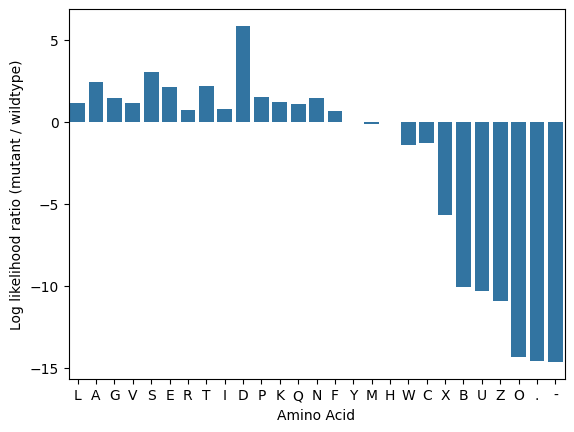

In [13]:
# Identify token index for wt amino acid
wildtype_amino_acid = original_sequence[mask_index]
wildtype_amino_acid_index = alphabet.tok_to_idx[wildtype_amino_acid]

# For each amino acid in the list of 'standard tokens', calculate LLR against wt
mutant_llr_ratios = []
for character in alphabet.standard_toks:
  mutant_amino_acid_index = alphabet.tok_to_idx[character]

  mutant_llr_ratios.append(torch.log(
    protein_probs[mask_index, mutant_amino_acid_index] /
    protein_probs[mask_index, wildtype_amino_acid_index]
  ).item())

# Plot results
f = sns.barplot(mutant_llr_ratios)
f.set_xticks(range(len(mutant_llr_ratios)))
f.set_xticklabels(alphabet.standard_toks)
plt.xlabel("Amino Acid")
plt.ylabel("Log likelihood ratio (mutant / wildtype)")
plt.show()

# Method #2: Embedding Analysis

The embedding analysis approach, like the direct prediction method, uses the pre-trained model as is. However, rather than obtaining probability or token predictions, the embedding analysis method uses the embeddings (an internal numerical representation) of the protein sequences computed by the model for downstream analyses such as visualization and clustering.

Below, we are interested in visualizing the embeddings of protein sequences computed by ESM2 to determine if they can characterize the localization (cytosol or membrane) of proteins. We will first embed all of our protein sequences, by passing the sequences (with no masks) through the model and extracting the internal representation. There are multiple layers at which an embedding _could_ be extracted, here we use the final layer of the model.

These embeddings are originally high dimensional (e.g. in the model used here, each sequence is represented by a list of 320 numbers). In order easily visualize them, we use UMAP to reduce the embeddings to 2 dimensions. Finally we will plot the 2-dimensional embeddings and color-code them by protein localization to see whether any patterns emerge.

In [14]:
def generate_esm_embeddings(
        model: ESM2,
        batch_converter: BatchConverter,
        sequences: list[str],
        embedding_layer: int,
        average_embeddings: bool = False,
        batch_size: int = 2
) -> torch.FloatTensor:
    """Generate embeddings of protein sequences using an ESM2 model.

    :param model: A pre-trained ESM2 model.
    :param batch_converter: An ESM2 batch converter.
    :param sequences: A list of tuples of (name, sequence) for the proteins.
    :param embedding_layer: Layer of the ESM2 model from which to will extract embeddings.
    :param average_embeddings: Whether to average the residue embeddings for each protein.
    :param batch_size: The batch size (# of protein sequences per batch).
    :return: A Torch FloatTensor of sequence embeddings.
      If average_embeddings=True, size is (num_sequences, embedding_size).
      If average_embeddings=False, size is (num_sequences, sequence_length, embedding_size).
    """
    # Convert protein sequences to (name, sequence) format expected by ESM2
    name_sequences = [(f"protein_{i}", sequence) for i, sequence in enumerate(sequences)]

    # Set up list to store computed embeddings
    embeddings = []

    # Make probability predictions on all sequences
    with torch.no_grad():
        # Iterate over batches of sequences
        for i in trange(0, len(sequences), batch_size):
            # Extract batch data
            batch_name_sequences = name_sequences[i:i + batch_size]

            # Convert batch data to ESM2 format
            batch_labels, batch_strs, batch_tokens = batch_converter(batch_name_sequences)

            # Calculate the length of each sequence in a batch
            batch_lengths = (batch_tokens != alphabet.padding_idx).sum(1)

            # Subtract 2 from each to remove start and end tokens
            batch_lengths -= 2

            # Compute embeddings for the sequences
            results = model(batch_tokens, repr_layers=[embedding_layer], return_contacts=False)

            # Get per-amino acid embeddings for the selected layer
            batch_embeddings = results['representations'][embedding_layer]

            # Extract embeddings and optionally average across the sequence
            for (name, _,), embedding, sequence_len in zip(batch_name_sequences, batch_embeddings, batch_lengths):
                # Extract embeddings for amino acids without start, end, or pad tokens
                embedding = embedding[1 : sequence_len + 1]

                # Optionally, average embeddings across amino acids in the sequence
                if average_embeddings:
                    embedding = embedding.mean(dim=0)

                # Save embeddings
                embeddings.append(embedding)

    # Stack embeddings across sequences
    embeddings = torch.stack(embeddings)

    return embeddings

In [15]:
# Compute embeddings for all sequences (with averaging to give a single embedding per sequence)
# This should take about 40 seconds for 50 sequences on the default Colab CPU
embeddings = generate_esm_embeddings(
    model=model,
    batch_converter=batch_converter,
    sequences=sequences,
    embedding_layer=final_layer,
    average_embeddings=True
)

print(embeddings.shape)

100%|██████████| 50/50 [00:53<00:00,  1.07s/it]

torch.Size([100, 320])


We see the embeddings have a shape of 200 (number of sequences) x 320 (embedding dimension). This embedding dimension depends on your model of choice so if you use a model other than `esm_t6_8M_UR50D`, the embedding dimension might differ.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


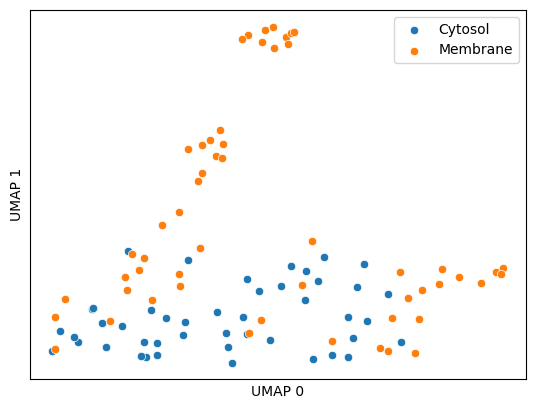

In [16]:
# Apply UMAP to reduce the embeddings to two dimensions
embeddings_2d = UMAP(random_state=0).fit_transform(embeddings)

# Plot the UMAP of embeddings, colored by cytosol/membrane label
sns.scatterplot(
    x=embeddings_2d[labels == 0, 0],
    y=embeddings_2d[labels == 0, 1],
    label="Cytosol"
)
sns.scatterplot(
    x=embeddings_2d[labels == 1, 0],
    y=embeddings_2d[labels == 1, 1],
    label="Membrane"
)

plt.xlabel("UMAP 0")
plt.ylabel("UMAP 1")

plt.xticks([])
plt.yticks([])

plt.legend()

plt.show()

# Method #3: Transfer Learning

The transfer learning method starts with the pre-trained language model but applies additional training to adapt the model to a particular downstream application.

There are two general techniques for applying transfer learning.

1. **Train on Embeddings:** Given limited data and compute, one transfer learning approach is to use the pre-trained model to compute embeddings for each sequence and then train a separate, typically smaller, model to predict the downstream task from those embeddings.

2. **Fine-Tune:** Given sufficient data and compute, another transfer learning method is to fine-tune (further train) the language model itself. This could involve fine-tuning some or all of the layers of the model.

Below, we demonstrate both transfer learning techniques for predicting protein localization

## Method 3-1: Train on Embeddings

For this transfer learning method, we will use the protein sequence embeddings we previously computed in Method 2 and train a small XGBoost model with those embeddings as input to predict protein localization.

In [ ]:
# Load a function to compute accuracy
accuracy = load("accuracy")

In [ ]:
# Separate the embeddings into train and test
train_embeddings = embeddings[:len(train_sequences)]
test_embeddings = embeddings[len(train_sequences):]

In [ ]:
# Train an XGB classifier on the training data (embeddings and labels)
xgb_model = XGBClassifier(random_state=0).fit(train_embeddings, train_labels)

In [ ]:
# Use the trained XGB classifier to make predictions on the test data
test_preds = xgb_model.predict(test_embeddings)

In [ ]:
# Evaluate the XGB test predictions
print(f"XGB test accuracy = {accuracy.compute(predictions=test_preds, references=test_labels)['accuracy']}")

XGB test accuracy = 0.84


## Method 3-2: Fine-Tune

For this transfer learning method, we will fine-tune the entire ESM2 model to predict protein localization.

Since our protein localization model requires a classification layer at the end of the model, we will load the ESM2 model using an alternate mechanism that replaces the final layer of the model (which typically predicts an amino acid _per position_ of the sequence) with a classification layer that predicts 1 value _per sequence_.

This should take about 4.5 minutes to train in the Colab.


**Technical Notes**

When fine-tuning we need to explicitely define our _tokenizer_. A tokenizer turns a protein representation from a sequence of strings into a sequence of "tokens" (integer numbers) that can be fed into the network. In the earlier example, the tokenization process is abstracted away but here we must run it manually.

In [ ]:
# Specify the ESM2 model
model_name = "esm2_t6_8M_UR50D"
model_checkpoint = f"facebook/{model_name}"

# Load a tokenizer that converts amino acids into the format expected by ESM2
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Load the ESM2 model
# Note: Ignore warnings some weights not being initialized since we need this for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

# Tokenize the train and test sequences
train_tokenized = tokenizer(train["sequences"].tolist())
test_tokenized = tokenizer(test["sequences"].tolist())

# Convert the train and test sequences into a Dataset object
train_dataset = Dataset.from_dict(train_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

# Add labels to the train and test datasets
train_dataset = train_dataset.add_column("labels", train["labels"].tolist())
test_dataset = test_dataset.add_column("labels", test["labels"].tolist())

# Define function to compute accuracy for model evaluation
def compute_accuracy(eval_pred: tuple[np.ndarray, np.ndarray]) -> float:
    """Computes the accuracy of predictions.

    :param eval_pred: A tuple of NumPy arrays containing an array of predictions
      and an array of labels.
    :return: The accuracy of the predictions.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Define the ESM2 training arguments
args = TrainingArguments(
    f"{model_name}-finetuned-localization",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

# Set up the Trainer for training the ESM2 model
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy,
)

# Fine-tune the ESM2 model and evaluate prediction accuracy
trainer.train()

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.663123,0.800000
2,No log,0.638601,0.820000
3,No log,0.629226,0.840000


TrainOutput(global_step=39, training_loss=0.6543462704389523, metrics={'train_runtime': 272.8323, 'train_samples_per_second': 0.55, 'train_steps_per_second': 0.143, 'total_flos': 2690325281460.0, 'train_loss': 0.6543462704389523, 'epoch': 3.0})

## Conclusion

In this toy example, we see that both embedding the sequences training on embeddings and fine-tuning the full model are both effective at predicting subcellular localization of these cytosolic and membrane proteins. As we saw in the embedding visualization, the internal embedding of the model already separates many of these proteins, so the extra learning task is not the most challenging. We also see that the fine-tuning method is both more complicated fro the user and takes quite a bit longer than training on the embedding. For this example task, the extra effort and time do improve the performance. However, this can be quite task-dependent, and for more complicated tasks, the extra computational power can be critical.